In [28]:
!pip install brisque --quiet
!pip install pypiqe --quiet

In [29]:
import libsvm.svmutil as svmutil
svmutil.PRECOMPUTED = 4

In [30]:
from PIL import Image
from IPython.display import display
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from brisque import BRISQUE
from scipy.ndimage import generic_filter, median_filter as scipy_median_filter
from pypiqe import piqe

In [31]:
!gdown --id 1yTIitz7t5khZpI6JfRAIqf70597XpyMF --quiet
!gdown --id 1t0hdTpPgu20kkTA8yjJyazMO3CN97Ouu --quiet
!gdown --id 1HVpoLmmOBxvbKPtHWsQqrgV6LaEDQk8W --quiet
!gdown --id 1cUuO0ecusUSA-GSF16a6IxQ5_CK8FEWJ --quiet

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(


In [32]:
def add_gaussian_noise(image_path: str, output_gray_path: str = "example_gray.jpg",
    output_noisy_path: str = "noisy_image_std25.jpg", mean: float = 0, std: float = 25):

    image = Image.open(image_path)
    image_gray = image.convert("L")
    image_gray.save(output_gray_path)

    image_array = np.array(image_gray)

    gaussian_noise = np.random.normal(mean, std, image_array.shape)
    noisy_image = image_array + gaussian_noise
    noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)

    noisy_image_pil = Image.fromarray(noisy_image)
    noisy_image_pil.save(output_noisy_path)

    return noisy_image_pil

In [33]:
def compress_image(input_path, output_path, quality):
    image = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
    _, compressed_image = cv2.imencode('.jpg', image, encode_param)
    compressed_image.tofile(output_path)


In [34]:
def calculate_bitrate(image_path, compressed_image_path):
    with Image.open(image_path) as img:
        width, height = img.size
        total_pixels = width * height

    compressed_file_size = os.path.getsize(compressed_image_path)

    bitrate = (compressed_file_size * 8) / total_pixels
    return bitrate

In [35]:
def padding_for_filter(image, filter_size):
    pad_width = filter_size // 2
    padded_image = np.pad(image, pad_width=pad_width, mode='edge')
    return padded_image

In [36]:
class EdgeDetector:
    def __init__(self, window, tau1=20.0, tau2=16.0, tau3=2.3):
        self.window = window.copy()
        self.tau1, self.tau2, self.tau3 = tau1, tau2, tau3
    def step1(self):
        window_flat = self.window[1:4, 1:4].ravel()
        window_flat = np.sort(window_flat)  # Sort in-place
        j_max1, j_min1 = window_flat[-2], window_flat[1]
        r9 = j_max1 - j_min1
        t = (j_max1 + j_min1) / 2.0
        if r9 <= self.tau1 or self.window[2, 2] >= t:
            return False
        return True

    def step2(self):
        window_flat = self.window.ravel()
        order = np.sort(window_flat)
        s_h = order[21]
        t25_avg = np.mean(window_flat)
        return np.sum(t25_avg - self.window > s_h / self.tau2)

    def step3(self, count):
        stat = (count - 12.5) / 2.5
        return abs(stat) <= self.tau3

    def classify(self):
        if self.step1() and self.step3(self.step2()):
            return "Dominant Edge"
        return "Constant Region"

In [37]:
class TexelDetector:
    def __init__(self, window, beta=12):
        self.window = window.copy() # 5x5 ndarray
        self.n, _ = self.window.shape
        self.eta = int(self.n*self.n*4*0.125)
        self.beta = beta
    def subtract_mean(self):
        mean = np.mean(self.window)
        self.window -= mean
    def operate_thresholding(self):
        self.window = np.where(np.abs(self.window) < self.beta, 0, self.window)
    def compute_rnzc(self):
        dir = [(1, -1), (1, 0), (1, 1), (0, 1)]
        rnzc = 0
        for x in range(self.n):
            for y in range(self.n):
                for dx, dy in dir:
                    nx, ny = x + dx, y + dy
                    if 0 <= nx < self.n and 0 <= ny < self.n and self.window[nx, ny] * self.window[x, y] < 0:
                        rnzc += 1

        return rnzc
    def classify(self):
        self.subtract_mean()
        self.operate_thresholding()
        rnzc = self.compute_rnzc()
        if rnzc > self.eta:
            return "Texel" #texel
        return "QC Region" #QC region

In [38]:
class ThreeWayLabel:
    def __init__(self, window, tau1, tau2, tau3, beta):
        self.window = window.copy()
        self.n, _ = self.window.shape
        self.EdgeDetector = EdgeDetector(self.window, tau1, tau2, tau3)
        self.beta = beta
    def classify(self):
        """Classify pixel as Dominant Edge, Texel, or QC Region."""
        label = self.EdgeDetector.classify()
        if label == "Dominant Edge":
            return label
        return TexelDetector(self.window, self.beta).classify()

In [39]:
def get_edges(image_array, tau1, tau2, tau3, beta, window=5):
    """Label image pixels using three-way classification with vectorization."""
    half_pad = window // 2
    height, width = image_array.shape
    output_array = np.zeros((height, width), dtype=np.uint8)

    float_img = image_array.astype(np.float64)

    # Vectorized window extraction using stride_tricks
    from numpy.lib.stride_tricks import sliding_window_view
    windows = sliding_window_view(float_img, (window, window))
    windows = windows[::1, ::1].reshape(-1, window, window)

    # Apply ThreeWayLabel to each window
    labels = np.array([
        ThreeWayLabel(w, tau1, tau2, tau3, beta).classify()
        for w in windows
    ]).reshape(height - 2 * half_pad, width - 2 * half_pad)

    # Map labels to output values
    label_map = {'Dominant Edge': 0, 'Texel': 128, 'QC Region': 255}
    output_array[half_pad:height-half_pad, half_pad:width-half_pad] = np.vectorize(label_map.get)(labels)

    # Morphological dilation
    edge_mask = (output_array == 0).astype(np.uint8)
    output_array[cv2.dilate(edge_mask, np.ones((1, 3), dtype=np.uint8)) == 1] = 0
    return output_array

In [40]:
def median_filter(image_array, x, y, window):
    """Apply median filter to a window."""
    half_pad = window // 2
    return np.median(image_array[x-half_pad:x+half_pad+1, y-half_pad:y+half_pad+1])

In [41]:
def d_filter(image_array, x, y, window):
    """Vectorized D-filter for a window."""
    half_pad = window // 2
    arr = image_array[x-half_pad:x+half_pad+1, y-half_pad:y+half_pad+1].flatten()
    arr.sort()
    n = arr.shape[0]
    m = (n + 1) // 2
    a = np.zeros(m)
    for i in range(m):
        a[i] = (arr[i] + arr[n - i - 1]) / 2
    return np.median(a)

In [42]:
def Multistage_median_filter(image_array, x, y, window_size):
    half_w = window_size // 2
    height, width = image_array.shape

    subwindows = []
    for di, dj in [(0, 1), (1, 0), (1, 1), (-1, 1)]:
        subwindow = []
        for offset in range(-half_w, half_w + 1):
            x, y = x + di * offset, y + dj * offset
            if 0 <= x < height and 0 <= y < width:
                subwindow.append(image_array[x, y])
        subwindows.append(subwindow)
    medians = [np.median(subwindow) for subwindow in subwindows]

    max_median = np.max(medians)
    min_median = np.min(medians)
    central_pixel = image_array[x, y]
    output = np.median([max_median, min_median, central_pixel])
    return output

In [43]:
class AdaptiveFilterScheme1:
    def __init__(self, image, edge_image, d_fil_times=2, window=5):
        self.half_pad = window // 2
        self.height, self.width = image.shape
        self.image = padding_for_filter(image.copy(), window).astype(np.float64)
        self.label = padding_for_filter(edge_image.copy(), window)
        self.d_fil_times = d_fil_times

    def run(self):
        # A 5x5 or 7x7 median filtering is used to smooth the edge points
        for x in range(self.half_pad, self.height - self.half_pad):
            for y in range(self.half_pad, self.width - self.half_pad):
                if self.label[x, y] == 0: # or self.is_edge[x, y] == 1:
                    self.image[x, y] = median_filter(self.image, x, y, 5)

        # The filtering is followed by one or two passes of 3x3 D filtering over the QC regions
        for _ in range(self.d_fil_times):
            for x in range(self.half_pad, self.height - self.half_pad):
                for y in range(self.half_pad, self.width - self.half_pad):
                    if self.label[x, y] == 255: # and self.is_edge[x, y] == 1:
                        self.image[x, y] = d_filter(self.image, x, y, 3)

        self.image = self.image[self.half_pad:self.half_pad+self.height, self.half_pad:self.half_pad+self.width]
        return self.image

In [44]:
class AdaptiveFilterScheme2:
    def __init__(self, image, edge_image, window=5):
        assert window % 2 == 1
        self.half_pad = window // 2
        self.height, self.width = image.shape
        self.image = padding_for_filter(image.copy(), window).astype(np.float64)
        self.label = padding_for_filter(edge_image.copy(), window)

    def run(self):
        # One pass of 3x3 D filtering over the QC regions
        for x in range(self.half_pad, self.height - self.half_pad):
            for y in range(self.half_pad, self.width - self.half_pad):
                if self.label[x, y] == 255: # and self.is_edge[x, y] != 1:
                    self.image[x, y] = d_filter(self.image, x, y, 3)

        # is followed by 5x5 multi-stage median filtering to smooth the edge points
        # where the preceding and the succeeding points of any edge point
        # are also considered as edge points.
        for x in range(self.half_pad, self.height - self.half_pad):
            for y in range(self.half_pad, self.width - self.half_pad):
                if self.label[x, y] == 0: # or self.is_edge[x, y] == 1:
                    self.image[x, y] = Multistage_median_filter(self.image, x, y, 5)

        # The filtering is followed by one pass of 3x3 thresholded D filtering over the entire image.
        for x in range(self.half_pad, self.height - self.half_pad):
            for y in range(self.half_pad, self.width - self.half_pad):
                    self.image[x, y] = d_filter(self.image, x, y, 3)

        self.image = self.image[self.half_pad:self.half_pad+self.height, self.half_pad:self.half_pad+self.width]
        return self.image

In [45]:
def display_4_images(compressed_image, scheme2_image, scheme1_image, three_way_image):
    images = [compressed_image, scheme2_image, scheme1_image, three_way_image]

    titles = [
        "(a) Original Image",
        "(b) Enhanced image using scheme (2)",
        "(c) Enhanced image using scheme (1)",
        "(d) 3-way pixel labeling of Fig. 1(a)"
    ]

    fig, axes = plt.subplots(2, 2, figsize=(10, 8))

    for ax, img, title in zip(axes.ravel(), images, titles):
        ax.imshow(img, cmap="gray")
        ax.set_title(title, fontsize=10)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

In [46]:
def calculate_M1_qc(original, processed, qc_mask):
    """Calculate M1 metric for QC regions."""
    qc_indices = np.where(qc_mask == 255)
    diff = original[qc_indices] - processed[qc_indices]
    return np.mean(np.abs(np.mean(diff) - diff))

In [47]:
def calculate_brisque(image):
    brisque = BRISQUE(url=False)
    return brisque.score(image.convert('RGB'))

In [48]:
def calculate_piqe(gray_image):
    """Calculate PIQE score."""
    return piqe(np.array(gray_image))[0]

In [49]:
class FullPipeline:
    def __init__(self, image_path, tau1, tau2, tau3, beta):
        self.image_path = image_path
        self.tau1, self.tau2, self.tau3, self.beta = tau1, tau2, tau3, beta
        self.original_array = self.compressed_array = None
        self.scheme1_array = self.scheme2_array = self.three_way_array = None
        self.original_image = self.compressed_image = None
        self.scheme1_image = self.scheme2_image = self.three_way_image = None

    def encode_image(self, quality = 10):
        self.original_image = Image.open(self.image_path).convert("L")
        self.original_image.save("example_gray.jpg")
        compress_image('example_gray.jpg', 'compressed_image.jpg', quality)
        self.compressed_image = Image.open('compressed_image.jpg').convert("L")
        bitrate = calculate_bitrate(self.image_path, 'compressed_image.jpg')

        print("Original Image")
        self.original_array = np.array(self.original_image)
        display(self.original_image)

        print("JPEG Encoded Image")
        self.compressed_array = np.array(self.compressed_image)
        display(self.compressed_image)

        print(f"Bitrate: {bitrate:.3f} bit/pixel")

    def label_edges(self):
        image_array = self.compressed_array
        height, width = image_array.shape

        window = 5
        half_pad = window // 2
        padded_array = padding_for_filter(image_array, window)

        output_array = get_edges(padded_array, self.tau1, self.tau2, self.tau3, self.beta, window)
        self.three_way_image = Image.fromarray(output_array[half_pad:half_pad+height, half_pad:half_pad+width])

        print("Three-way Label Image")
        self.three_way_array = np.array(self.three_way_image)
        display(self.three_way_image)

    def apply_filters(self):
        image_array = self.compressed_array.astype(np.float64)

        adaptive_filter_1 = AdaptiveFilterScheme1(image_array.copy(), self.three_way_array.copy())
        self.scheme1_image = adaptive_filter_1.run()
        self.scheme1_image = np.array(self.scheme1_image).astype(np.uint8)
        self.scheme1_image = Image.fromarray(self.scheme1_image)
        print("Scheme 1 Filter")
        self.scheme1_array = np.array(self.scheme1_image)
        display(self.scheme1_image)

        adaptive_filter_2 = AdaptiveFilterScheme2(image_array.copy(), self.three_way_array.copy())
        self.scheme2_image = adaptive_filter_2.run()
        self.scheme2_image = np.array(self.scheme2_image).astype(np.uint8)
        self.scheme2_image = Image.fromarray(self.scheme2_image)
        print("Scheme 2 Filter")
        self.scheme2_array = np.array(self.scheme2_image)
        display(self.scheme2_image)

    def check_sizes(self):
        """Print image array shapes."""
        for name, arr in [
            ("Original", self.original_array),
            ("Compressed", self.compressed_array),
            ("Scheme 1", self.scheme1_array),
            ("Scheme 2", self.scheme2_array),
            ("Three-way", self.three_way_array)
        ]:
            print(f"{name} shape: {arr.shape}")

    def assess_quality(self):
        M1_original_qc = calculate_M1_qc(self.original_array, self.original_array, self.three_way_array)
        M1_compressed_qc = calculate_M1_qc(self.original_array, self.compressed_array, self.three_way_array)
        M1_scheme1_qc = calculate_M1_qc(self.original_array, self.scheme1_array, self.three_way_array)
        M1_scheme2_qc = calculate_M1_qc(self.original_array, self.scheme2_array, self.three_way_array)

        print("Original Image (QC regions):", M1_original_qc)
        print("Compressed Image (QC regions):", M1_compressed_qc)
        print("Scheme 1 Image (QC regions):", M1_scheme1_qc)
        print("Scheme 2 Image (QC regions):", M1_scheme2_qc)
        print()
        print("Original Brisque score:", calculate_brisque(self.compressed_image))
        print("Scheme 1 Brisque score:", calculate_brisque(self.scheme1_image))
        print("Scheme 2 Brisque score:", calculate_brisque(self.scheme2_image))
        print()
        print("Original PIQE score:", calculate_piqe(self.compressed_image))
        print("Scheme 1 PIQE score:", calculate_piqe(self.scheme1_image))
        print("Scheme 2 PIQE score:", calculate_piqe(self.scheme2_image))

    def run(self, quality = 10):
        self.encode_image(quality)
        self.label_edges()
        self.apply_filters()
        self.check_sizes()
        display_4_images(self.compressed_image, self.scheme2_image, self.scheme1_image, self.three_way_image)
        self.assess_quality()

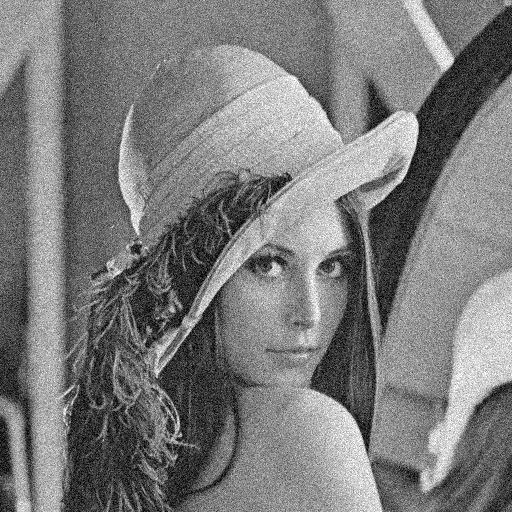

In [50]:
add_gaussian_noise(image_path='Lenna_(test_image).png', output_noisy_path='example_gray_20.jpg', std=20)

Original Image


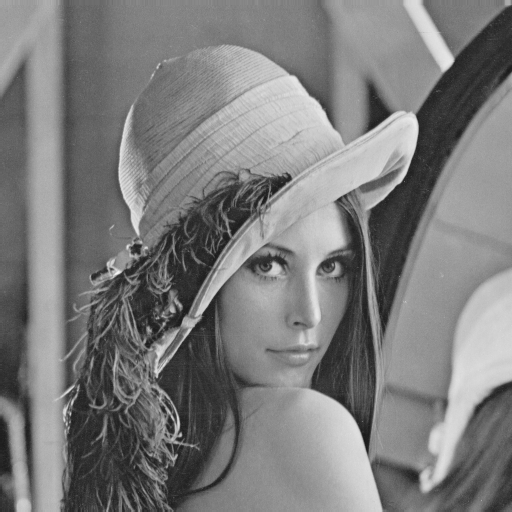

JPEG Encoded Image


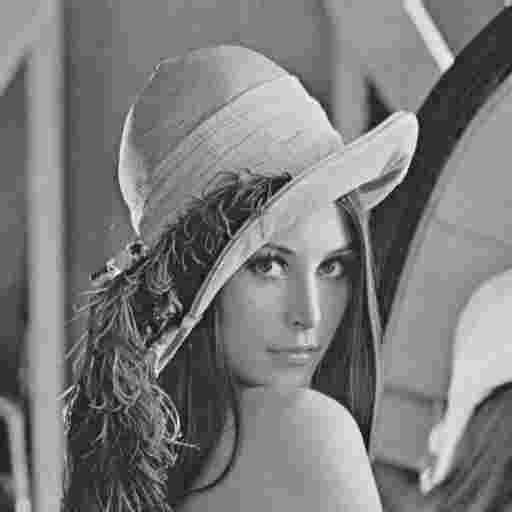

Bitrate: 0.248 bit/pixel
Three-way Label Image


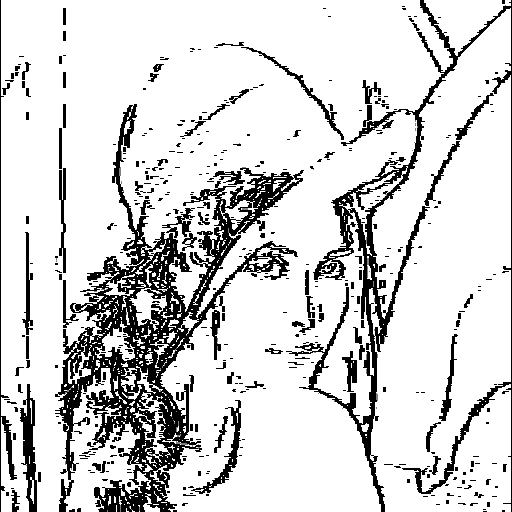

Scheme 1 Filter


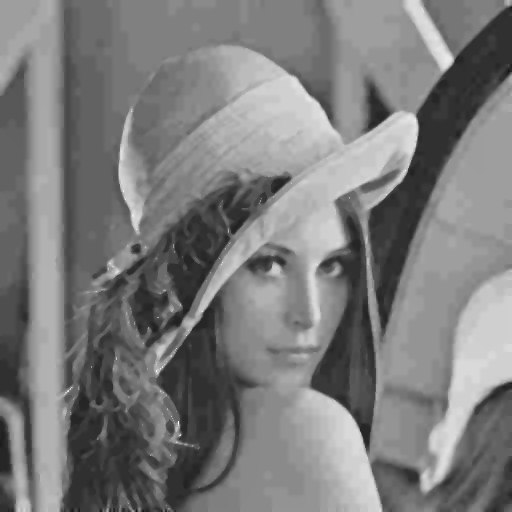

Scheme 2 Filter


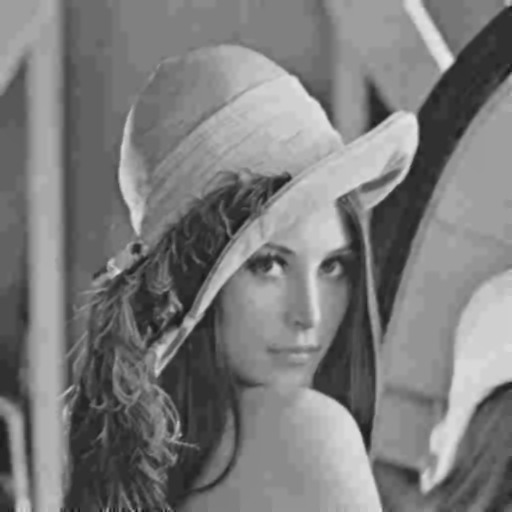

Original shape: (512, 512)
Compressed shape: (512, 512)
Scheme 1 shape: (512, 512)
Scheme 2 shape: (512, 512)
Three-way shape: (512, 512)


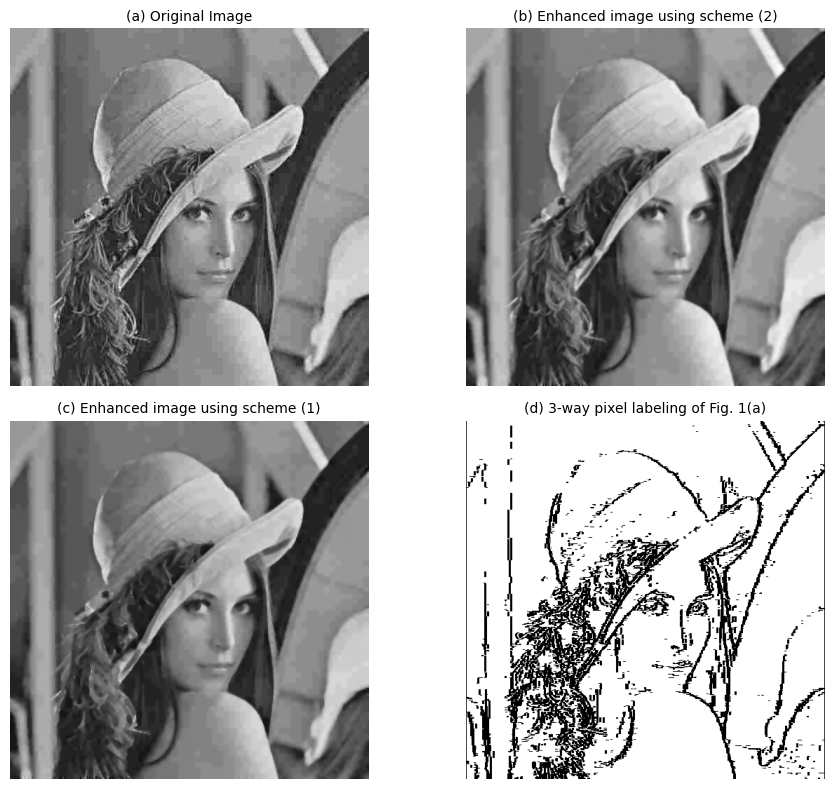

Original Image (QC regions): 0.0
Compressed Image (QC regions): 122.89721220885434
Scheme 1 Image (QC regions): 120.34309233451638
Scheme 2 Image (QC regions): 119.78891872916871

Original Brisque score: 67.71016498911737
Scheme 1 Brisque score: 66.74358911279816
Scheme 2 Brisque score: 63.1155239542712

Original PIQE score: 68.40312533329372
Scheme 1 PIQE score: 72.91080421893838
Scheme 2 PIQE score: 67.7679925818574


In [52]:
# Run pipeline for each image with specified parameters
for image_path, params in [
    # ('benchmark.png', {'tau1': 20.0, 'tau2': 5.0, 'tau3': 2.3, 'beta': 6}),
    # ('example_gray_15.jpg', {'tau1': 20.0, 'tau2': 16.0, 'tau3': 2.3, 'beta': 7}),
    # ('example_gray_20.jpg', {'tau1': 20.0, 'tau2': 16.0, 'tau3': 2.3, 'beta': 12}),
    ('Lenna_(test_image).png', {'tau1': 20.0, 'tau2': 16.0, 'tau3': 2.3, 'beta': 12})
]:
    pipeline = FullPipeline(image_path, **params)
    pipeline.run()

# Demo

In [54]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 115.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.1 MB/s eta 0:00:00


In [57]:
import gradio as gr
import numpy as np
from PIL import Image
import cv2
import os
from brisque import BRISQUE
from pypiqe import piqe
import matplotlib.pyplot as plt

def add_gaussian_noise(image, std=25):
    image_array = np.array(image.convert("L"))
    gaussian_noise = np.random.normal(0, std, image_array.shape)
    noisy_image = np.clip(image_array + gaussian_noise, 0, 255).astype(np.uint8)
    return Image.fromarray(noisy_image)

def add_salt_pepper_noise(image, prob=0.05):
    image_array = np.array(image.convert("L"))
    output = image_array.copy()
    # Salt noise
    num_salt = np.ceil(prob * image_array.size * 0.5)
    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image_array.shape]
    output[coords[0], coords[1]] = 255
    # Pepper noise
    num_pepper = np.ceil(prob * image_array.size * 0.5)
    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image_array.shape]
    output[coords[0], coords[1]] = 0
    return Image.fromarray(output)

def apply_noise(image, noise_type, noise_level):
    if noise_type == "Gaussian":
        return add_gaussian_noise(image, std=noise_level)
    elif noise_type == "Salt & Pepper":
        return add_salt_pepper_noise(image, prob=noise_level / 1000)
    else:  # None
        return image.convert("L")

def compress_image(input_path, output_path, quality):
    image = cv2.imread(input_path, 0)
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
    _, compressed_image = cv2.imencode('.jpg', image, encode_param)
    with open(output_path, 'wb') as f:
        f.write(compressed_image)

def calculate_bitrate(image_path, compressed_image_path):
    with Image.open(image_path) as img:
        width, height = img.size
        total_pixels = width * height
    compressed_file_size = os.path.getsize(compressed_image_path)
    bitrate = (compressed_file_size * 8) / total_pixels
    return bitrate

def padding_for_filter(image, filter_size):
    pad_width = filter_size // 2
    padded_image = np.pad(image, pad_width=pad_width, mode='edge')
    return padded_image

class EdgeDetector:
    def __init__(self, window, tau1=20.0, tau2=16.0, tau3=2.3):
        self.window = window.copy()
        self.tau1 = tau1
        self.tau2 = tau2
        self.tau3 = tau3
    def step1(self):
        window = self.window[1:4,1:4].flatten()
        window.sort()
        J_max1 = window[-2]
        J_min1 = window[1]
        R9 = J_max1 - J_min1
        T = (J_max1 + J_min1) / 2.0
        T0 = self.window[2, 2]
        if R9 <= self.tau1 or T0 >= T:
            return False
        else:
            return True
    def step2(self):
        window = self.window
        order = window.flatten()
        order.sort()
        S_h = order[21]
        T25_avg = np.average(order)
        count = 0
        for i in range(5):
            for j in range(5):
                s_i = T25_avg - self.window[i, j]
                if s_i > S_h / self.tau2:
                    count += 1
        return count
    def step3(self, count):
        stat = (count - 12.5) / 2.5
        if abs(stat) <= self.tau3:
            return True
        else:
            return False
    def classify(self):
        if self.step1():
            count = self.step2()
            if self.step3(count):
                return "Dominant Edge"
        return "Constant Region"

class TexelDetector:
    def __init__(self, window, beta=12):
        self.window = window.copy()
        self.n, _ = self.window.shape
        self.eta = int(self.n*self.n*4*0.125)
        self.beta = beta
    def subtract_mean(self):
        mean = np.mean(self.window)
        self.window -= mean
    def operate_thresholding(self):
        for i in range(self.n):
            for j in range(self.n):
                if abs(self.window[i, j]) < self.beta:
                    self.window[i, j] = 0
    def compute_rnzc(self):
        dir = [(1, -1), (1, 0), (1, 1), (0, 1)]
        rnzc = 0
        for x in range(self.n):
            for y in range(self.n):
                for dx, dy in dir:
                    nx, ny = x + dx, y + dy
                    if 0 <= nx < self.n and 0 <= ny < self.n and self.window[nx, ny] * self.window[x, y] < 0:
                        rnzc += 1
        return rnzc
    def classify(self):
        self.subtract_mean()
        self.operate_thresholding()
        rnzc = self.compute_rnzc()
        if rnzc > self.eta:
            return "Texel"
        else:
            return "QC Region"

class ThreeWayLabel:
    def __init__(self, window, tau1, tau2, tau3, beta):
        self.window = window.copy()
        self.n, _ = self.window.shape
        self.EdgeDetector = EdgeDetector(self.window, tau1, tau2, tau3)
        self.beta = beta
    def classify(self):
        label = self.EdgeDetector.classify()
        if label == "Dominant Edge":
            return "Dominant Edge"
        elif label == "Constant Region":
            self.TDetector = TexelDetector(self.window, self.beta)
            label = self.TDetector.classify()
            return label
        else:
            assert False

def get_edges(image_array, tau1, tau2, tau3, beta, window=5):
    assert window % 2 == 1
    half_pad = window // 2
    height, width = image_array.shape
    output_array = np.zeros_like(image_array)
    for x in range(half_pad, height - half_pad):
        for y in range(half_pad, width - half_pad):
            window = image_array[x-2:x+3, y-2:y+3].astype(np.float64)
            three_way_label = ThreeWayLabel(window, tau1, tau2, tau3, beta)
            label = three_way_label.classify()
            if label == "Texel":
                output_array[x, y] = 128
            elif label == "QC Region":
                output_array[x, y] = 255
            else:
                assert label == "Dominant Edge"
                output_array[x, y] = 0
    horizontal_line = np.ones((1, 3), dtype=np.uint8)
    edge_mask = (output_array == 0).astype(np.uint8)
    dilated_edges = cv2.dilate(edge_mask, horizontal_line, iterations=1)
    output_array[dilated_edges == 1] = 0
    return output_array

def Median_filter(image_array, x, y, window):
    assert window % 2 == 1
    half_pad = window // 2
    window = image_array[x-half_pad:x+half_pad+1, y-half_pad:y+half_pad+1]
    return np.median(window)

def D_filter(image_array, x, y, window):
    assert window % 2 == 1
    half_pad = window // 2
    arr = image_array[x-half_pad:x+half_pad+1, y-half_pad:y+half_pad+1].flatten()
    arr.sort()
    n = arr.shape[0]
    m = (n + 1) // 2
    a = np.zeros(m)
    for i in range(m):
        a[i] = (arr[i] + arr[n - i - 1]) / 2
    return np.median(a)

def Multistage_median_filter(image_array, x, y, window_size):
    half_w = window_size // 2
    height, width = image_array.shape
    subwindows = []
    for di, dj in [(0, 1), (1, 0), (1, 1), (-1, 1)]:
        subwindow = []
        for offset in range(-half_w, half_w + 1):
            x, y = x + di * offset, y + dj * offset
            if 0 <= x < height and 0 <= y < width:
                subwindow.append(image_array[x, y])
        subwindows.append(subwindow)
    medians = [np.median(subwindow) for subwindow in subwindows]
    max_median = np.max(medians)
    min_median = np.min(medians)
    central_pixel = image_array[x, y]
    output = np.median([max_median, min_median, central_pixel])
    return output

class AdaptiveFilterScheme1:
    def __init__(self, image, edge_image, d_fil_times=2, window=5):
        assert 1 <= d_fil_times <= 2
        assert window % 2 == 1
        self.half_pad = window // 2
        self.height, self.width = image.shape
        self.image = padding_for_filter(image.copy(), window)
        self.image = self.image.astype(np.float64)
        self.label = padding_for_filter(edge_image.copy(), window)
        self.d_fil_times = d_fil_times
    def run(self):
        for x in range(self.half_pad, self.height - self.half_pad):
            for y in range(self.half_pad, self.width - self.half_pad):
                if self.label[x, y] == 0:
                    self.image[x, y] = Median_filter(self.image, x, y, 5)
        for _ in range(self.d_fil_times):
            for x in range(self.half_pad, self.height - self.half_pad):
                for y in range(self.half_pad, self.width - self.half_pad):
                    if self.label[x, y] == 255:
                        self.image[x, y] = D_filter(self.image, x, y, 3)
        self.image = self.image[self.half_pad:self.half_pad+self.height, self.half_pad:self.half_pad+self.width]
        return self.image

class AdaptiveFilterScheme2:
    def __init__(self, image, edge_image, window=5):
        assert window % 2 == 1
        self.half_pad = window // 2
        self.height, self.width = image.shape
        self.image = padding_for_filter(image.copy(), window)
        self.image = self.image.astype(np.float64)
        self.label = padding_for_filter(edge_image.copy(), window)
    def run(self):
        for x in range(self.half_pad, self.height - self.half_pad):
            for y in range(self.half_pad, self.width - self.half_pad):
                if self.label[x, y] == 255:
                    self.image[x, y] = D_filter(self.image, x, y, 3)
        for x in range(self.half_pad, self.height - self.half_pad):
            for y in range(self.half_pad, self.width - self.half_pad):
                if self.label[x, y] == 0:
                    self.image[x, y] = Multistage_median_filter(self.image, x, y, 5)
        for x in range(self.half_pad, self.height - self.half_pad):
            for y in range(self.half_pad, self.width - self.half_pad):
                self.image[x, y] = D_filter(self.image, x, y, 3)
        self.image = self.image[self.half_pad:self.half_pad+self.height, self.half_pad:self.half_pad+self.width]
        return self.image

def calculate_M1_qc(original, processed, qc_mask):
    qc_indices = np.where(qc_mask == 255)
    difference_image = original[qc_indices] - processed[qc_indices]
    local_average = np.mean(difference_image)
    absolute_differences = np.abs(local_average - difference_image)
    M1 = np.sum(absolute_differences) / len(absolute_differences) if len(absolute_differences) > 0 else 0.0
    return M1

def calculate_brisque(image):
    assert image.mode == 'L'
    image = image.convert('RGB')
    brisque = BRISQUE(url=False)
    score = brisque.score(image)
    return score

def calculate_piqe(gray_image):
    gray_image_np = np.array(gray_image)
    score, _, _, _ = piqe(gray_image_np)
    return score

class FullPipeline:
    def __init__(self, image_path, tau1, tau2, tau3, beta):
        self.image_path = image_path
        self.original_image = None
        self.original_array = None
        self.compressed_image = None
        self.compressed_array = None
        self.scheme1_image = None
        self.scheme1_array = None
        self.scheme2_image = None
        self.scheme2_array = None
        self.three_way_image = None
        self.three_way_array = None
        self.tau1 = tau1
        self.tau2 = tau2
        self.tau3 = tau3
        self.beta = beta
    def encode_image(self, quality=10, noise_type="None", noise_level=25):
        self.original_image = Image.open(self.image_path)
        self.original_image = apply_noise(self.original_image, noise_type, noise_level)
        self.original_image.save("example_gray.jpg")
        compress_image('example_gray.jpg', 'compressed_image.jpg', quality)
        self.compressed_image = Image.open('compressed_image.jpg').convert("L")
        bitrate = calculate_bitrate('example_gray.jpg', 'compressed_image.jpg')
        self.original_array = np.array(self.original_image)
        self.compressed_array = np.array(self.compressed_image)
        return bitrate
    def label_edges(self):
        image_array = np.array(self.compressed_image)
        height, width = image_array.shape
        window = 5
        half_pad = window // 2
        image_array = padding_for_filter(image_array, window)
        output_array = get_edges(image_array, self.tau1, self.tau2, self.tau3, self.beta, window)
        self.three_way_image = Image.fromarray(output_array[half_pad:half_pad+height, half_pad:half_pad+width])
        self.three_way_array = np.array(self.three_way_image)
    def apply_filters(self):
        image_array = np.array(self.compressed_image).astype(np.float64)
        adaptive_filter_1 = AdaptiveFilterScheme1(image_array.copy(), self.three_way_array.copy())
        self.scheme1_image = adaptive_filter_1.run()
        self.scheme1_image = np.array(self.scheme1_image).astype(np.uint8)
        self.scheme1_image = Image.fromarray(self.scheme1_image)
        self.scheme1_array = np.array(self.scheme1_image)
        adaptive_filter_2 = AdaptiveFilterScheme2(image_array.copy(), self.three_way_array.copy())
        self.scheme2_image = adaptive_filter_2.run()
        self.scheme2_image = np.array(self.scheme2_image).astype(np.uint8)
        self.scheme2_image = Image.fromarray(self.scheme2_image)
        self.scheme2_array = np.array(self.scheme2_image)
    def assess_quality(self):
        M1_original_qc = calculate_M1_qc(self.original_array, self.original_array, self.three_way_array)
        M1_compressed_qc = calculate_M1_qc(self.original_array, self.compressed_array, self.three_way_array)
        M1_scheme1_qc = calculate_M1_qc(self.original_array, self.scheme1_array, self.three_way_array)
        M1_scheme2_qc = calculate_M1_qc(self.original_array, self.scheme2_array, self.three_way_array)
        brisque_compressed = calculate_brisque(self.compressed_image)
        brisque_scheme1 = calculate_brisque(self.scheme1_image)
        brisque_scheme2 = calculate_brisque(self.scheme2_image)
        piqe_compressed = calculate_piqe(self.compressed_image)
        piqe_scheme1 = calculate_piqe(self.scheme1_image)
        piqe_scheme2 = calculate_piqe(self.scheme2_image)
        return {
            "M1_original_qc": M1_original_qc,
            "M1_compressed_qc": M1_compressed_qc,
            "M1_scheme1_qc": M1_scheme1_qc,
            "M1_scheme2_qc": M1_scheme2_qc,
            "brisque_compressed": brisque_compressed,
            "brisque_scheme1": brisque_scheme1,
            "brisque_scheme2": brisque_scheme2,
            "piqe_compressed": piqe_compressed,
            "piqe_scheme1": piqe_scheme1,
            "piqe_scheme2": piqe_scheme2
        }
    def run(self, quality=10, noise_type="None", noise_level=25):
        bitrate = self.encode_image(quality, noise_type, noise_level)
        self.label_edges()
        self.apply_filters()
        quality_metrics = self.assess_quality()
        return self.original_image, self.compressed_image, self.scheme1_image, self.scheme2_image, self.three_way_image, bitrate, quality_metrics

def process_image(image, noise_type, noise_level, tau1, tau2, tau3, beta, quality):
    # Save uploaded image
    image_path = "uploaded_image.png"
    image.save(image_path)

    # Initialize and run pipeline
    pipeline = FullPipeline(image_path, tau1, tau2, tau3, beta)
    original_image, compressed_image, scheme1_image, scheme2_image, three_way_image, bitrate, quality_metrics = pipeline.run(quality, noise_type, noise_level)

    # Create a 2x3 plot for the images
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    images = [original_image, compressed_image, scheme2_image, scheme1_image, three_way_image]
    titles = [
        "(a) Original/Noisy Image",
        "(b) Compressed Image",
        "(c) Enhanced Image (Scheme 2)",
        "(d) Enhanced Image (Scheme 1)",
        "(e) 3-way Pixel Labeling"
    ]
    for ax, img, title in zip(axes.ravel(), images, titles):
        ax.imshow(img, cmap="gray")
        ax.set_title(title, fontsize=10)
        ax.axis("off")
    # Hide the last subplot if there are only 5 images
    axes[1, 2].axis("off")
    plt.tight_layout()

    # Save plot to image
    plot_path = "output_plot.png"
    plt.savefig(plot_path)
    plt.close()

    # Format quality metrics
    metrics_text = f"""
    **Bitrate**: {bitrate:.3f} bit/pixel

    **M1 Scores (QC regions)**:
    - Original: {quality_metrics['M1_original_qc']:.3f}
    - Compressed: {quality_metrics['M1_compressed_qc']:.3f}
    - Scheme 1: {quality_metrics['M1_scheme1_qc']:.3f}
    - Scheme 2: {quality_metrics['M1_scheme2_qc']:.3f}

    **BRISQUE Scores**:
    - Compressed: {quality_metrics['brisque_compressed']:.3f}
    - Scheme 1: {quality_metrics['brisque_scheme1']:.3f}
    - Scheme 2: {quality_metrics['brisque_scheme2']:.3f}

    **PIQE Scores**:
    - Compressed: {quality_metrics['piqe_compressed']:.3f}
    - Scheme 1: {quality_metrics['piqe_scheme1']:.3f}
    - Scheme 2: {quality_metrics['piqe_scheme2']:.3f}
    """

    return original_image, Image.open(plot_path), metrics_text

# Define Gradio interface
iface = gr.Interface(
    fn=process_image,
    inputs=[
        gr.Image(type="pil", label="Upload Image"),
        gr.Dropdown(choices=["None", "Gaussian", "Salt & Pepper"], value="None", label="Noise Type"),
        gr.Slider(minimum=0, maximum=50, value=25, step=1, label="Noise Level (std for Gaussian, prob*1000 for Salt & Pepper)"),
        gr.Slider(minimum=10, maximum=50, value=20, step=1, label="Tau1"),
        gr.Slider(minimum=1, maximum=20, value=5, step=0.25, label="Tau2"),
        gr.Slider(minimum=1, maximum=5, value=2.3, step=0.1, label="Tau3"),
        gr.Slider(minimum=1, maximum=20, value=12, step=1, label="Beta"),
        gr.Slider(minimum=1, maximum=100, value=10, step=1, label="JPEG Quality")
    ],
    outputs=[
        gr.Image(label="Original/Noisy Image"),
        gr.Image(label="Processed Images"),
        gr.Textbox(label="Quality Metrics")
    ],
    title="Image Processing Pipeline with Noise Selection",
    description="Upload an image, select noise type, adjust noise level, and tune parameters to process it using the adaptive filtering pipeline."
)

# Launch the interface
if __name__ == "__main__":
    iface.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://882f912c8d43d935ca.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
